# About Dataset
link https://www.kaggle.com/datasets/saadaliyaseen/climate-and-atmospheric-conditions-data/data

This dataset contains weather information recorded hourly in 2012. It includes details like temperature, humidity, wind speed, visibility, pressure, and weather conditions. Such data is commonly used for climate analysis, forecasting, and research.

## Imports

In [2]:
!pip install optuna

In [3]:
import kagglehub
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report

## Load the data

In [4]:
# Download latest version
path = kagglehub.dataset_download("saadaliyaseen/climate-and-atmospheric-conditions-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'climate-and-atmospheric-conditions-data' dataset.
Path to dataset files: /kaggle/input/climate-and-atmospheric-conditions-data


In [5]:
# The dataset is downloaded to the path variable from the previous cell
# We can list the files in the downloaded directory to see the available data
files = os.listdir(path)
print("Files in the dataset directory:", files)

# Assuming the main data file is a CSV and its name is in the files list,
# we will load the first CSV file found. You might need to adjust this
# if there are multiple CSVs or the main file has a specific name.
csv_files = [f for f in files if f.endswith('.csv')]
if csv_files:
    data_file_path = os.path.join(path, csv_files[0])
    df = pd.read_csv(data_file_path)
    print("\nDataFrame loaded successfully:")
    display(df.head())
else:
    print("\nNo CSV files found in the dataset directory.")

Files in the dataset directory: ['Project 1 - Weather Dataset.csv']

DataFrame loaded successfully:


,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog


## Explore the data

In [6]:
df

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog
...,...,...,...,...,...,...,...,...
8779,12/31/2012 19:00,0.1,-2.7,81,30,9.7,100.13,Snow
8780,12/31/2012 20:00,0.2,-2.4,83,24,9.7,100.03,Snow
8781,12/31/2012 21:00,-0.5,-1.5,93,28,4.8,99.95,Snow
8782,12/31/2012 22:00,-0.2,-1.8,89,28,9.7,99.91,Snow


In [7]:
df.isnull().sum().sum()

np.int64(0)

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date/Time         8784 non-null   object 
 1   Temp_C            8784 non-null   float64
 2   Dew Point Temp_C  8784 non-null   float64
 3   Rel Hum_%         8784 non-null   int64  
 4   Wind Speed_km/h   8784 non-null   int64  
 5   Visibility_km     8784 non-null   float64
 6   Press_kPa         8784 non-null   float64
 7   Weather           8784 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 549.1+ KB


In [10]:
numerical_cols = df.select_dtypes(include=['int64', 'float64'])
df_numerical = df[numerical_cols.columns]
display(df_numerical.head())

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa
0,-1.8,-3.9,86,4,8.0,101.24
1,-1.8,-3.7,87,4,8.0,101.24
2,-1.8,-3.4,89,7,4.0,101.26
3,-1.5,-3.2,88,6,4.0,101.27
4,-1.5,-3.3,88,7,4.8,101.23


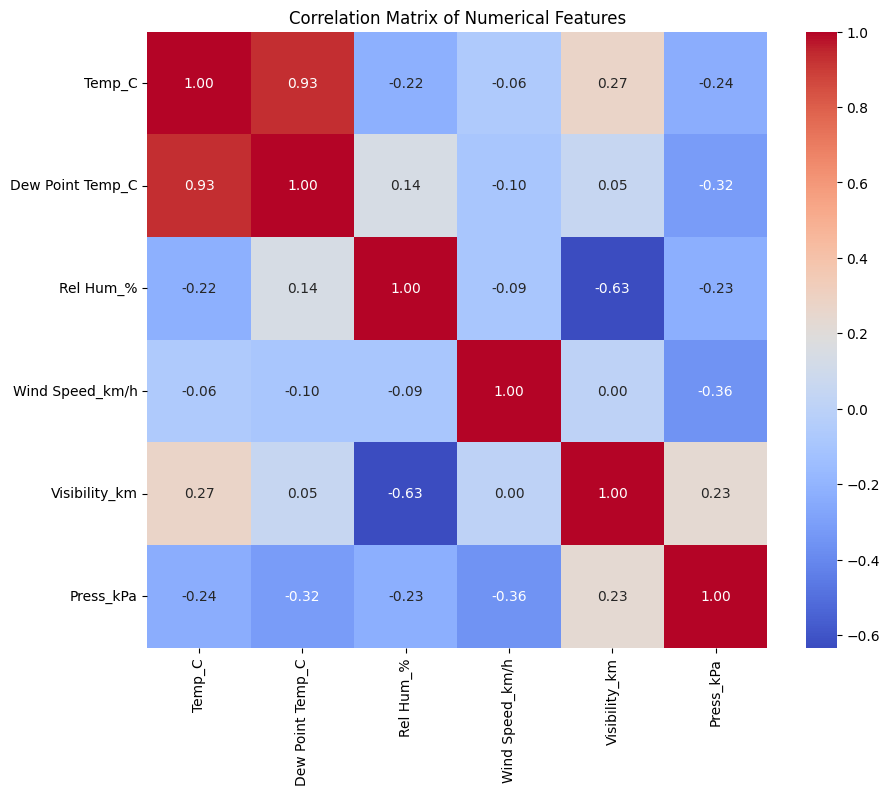

In [11]:
correlation_matrix = df_numerical.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

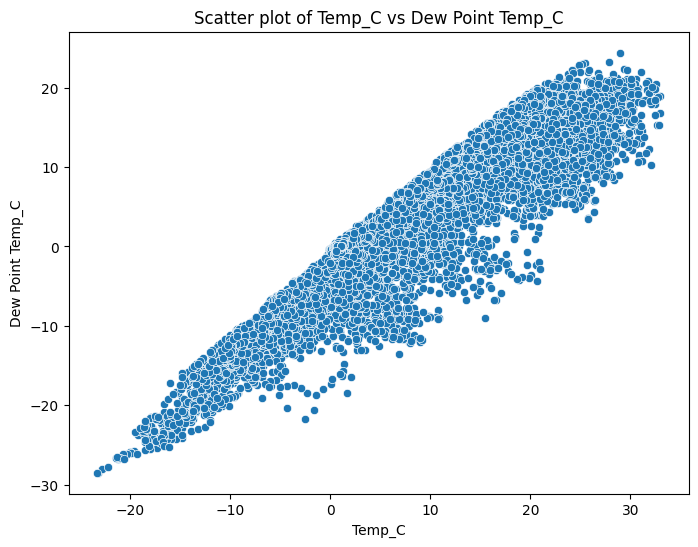

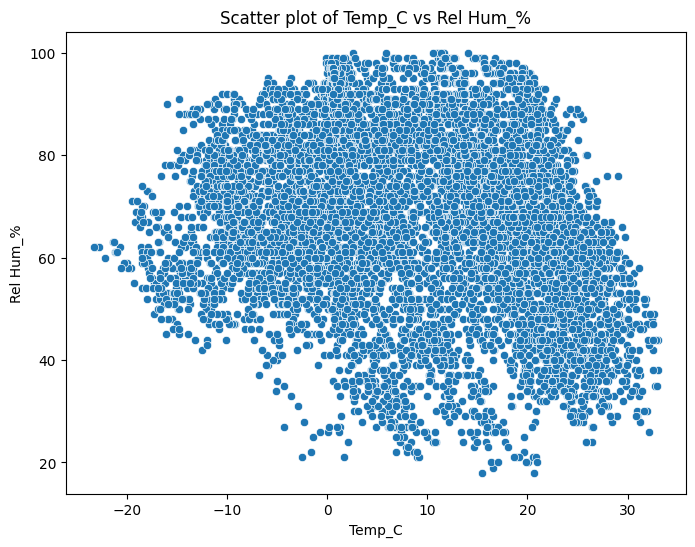

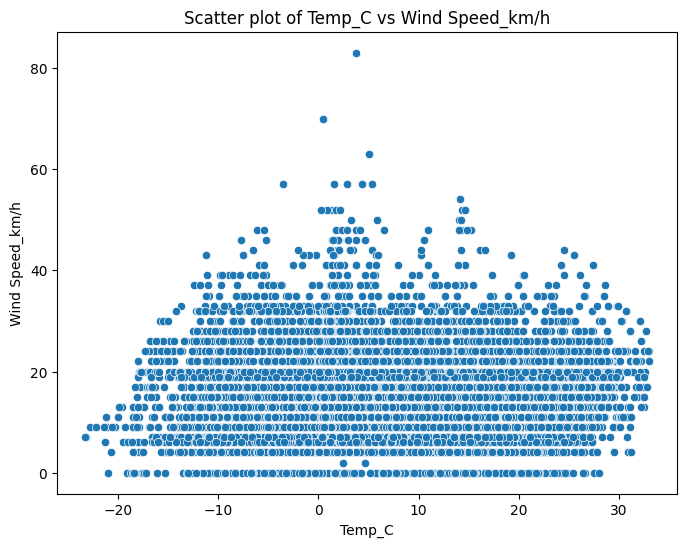

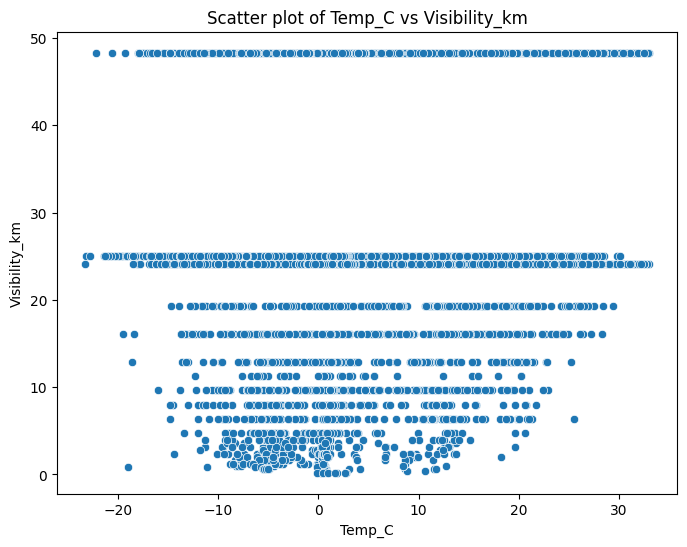

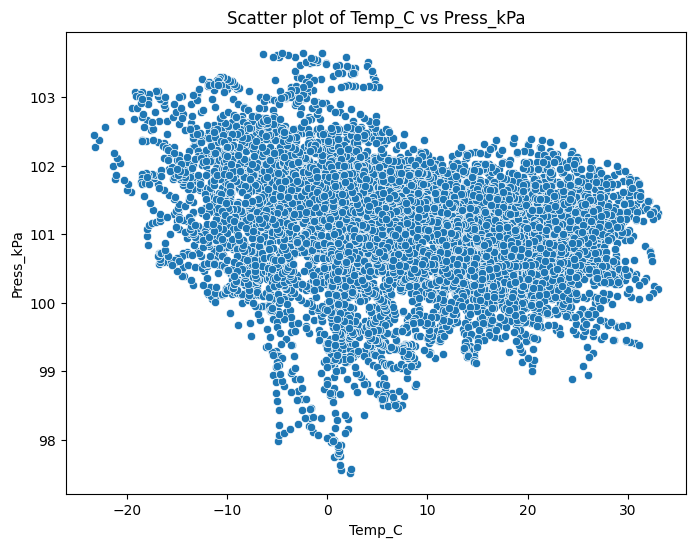

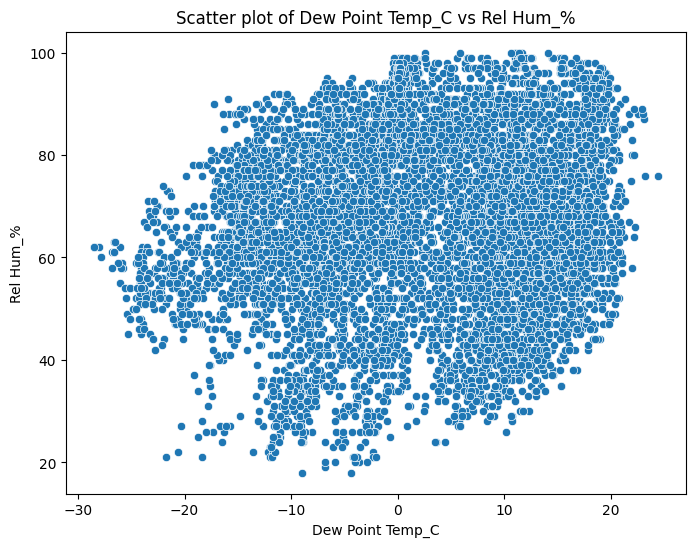

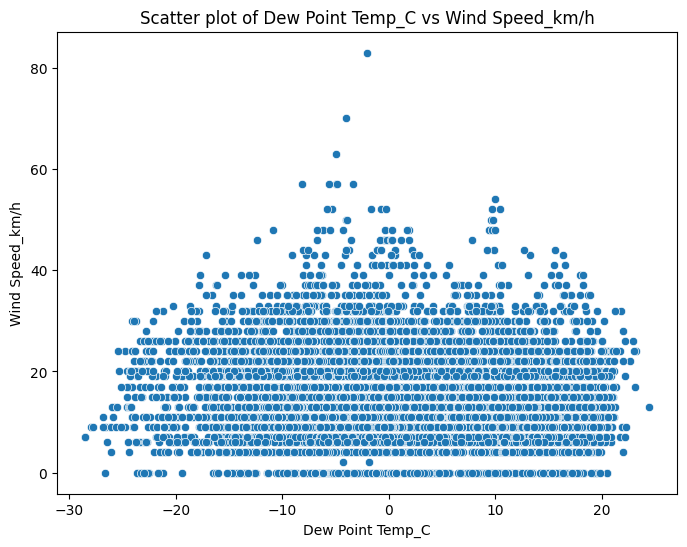

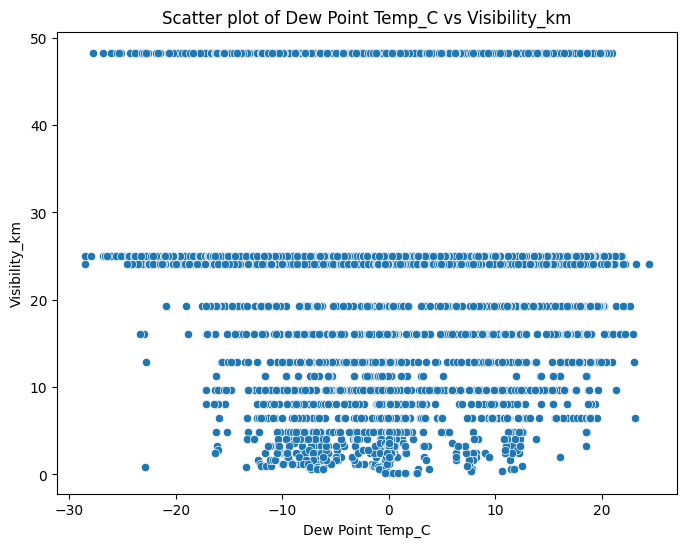

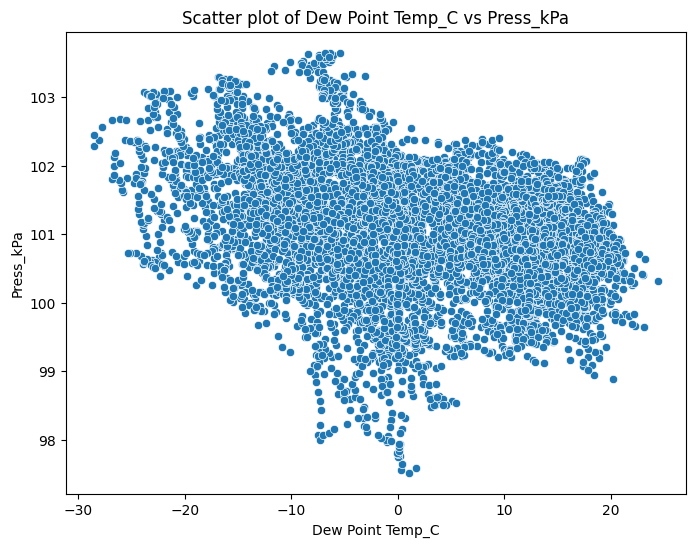

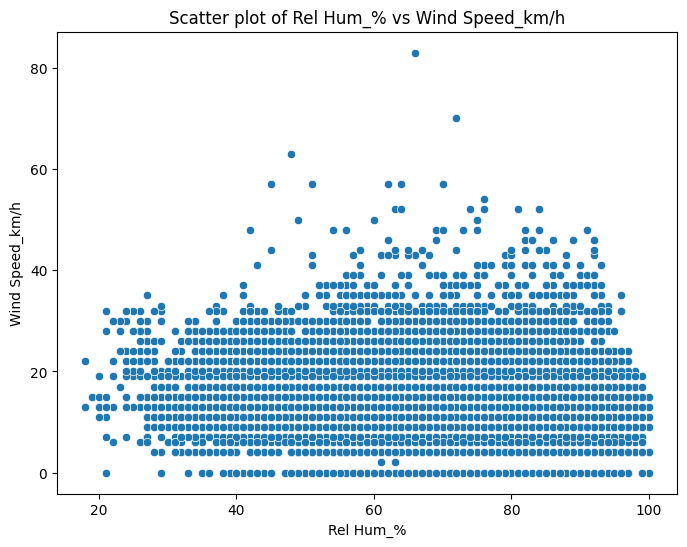

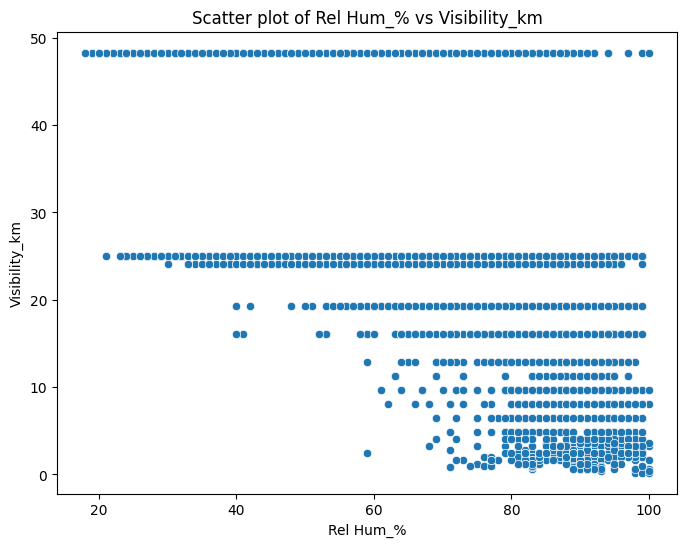

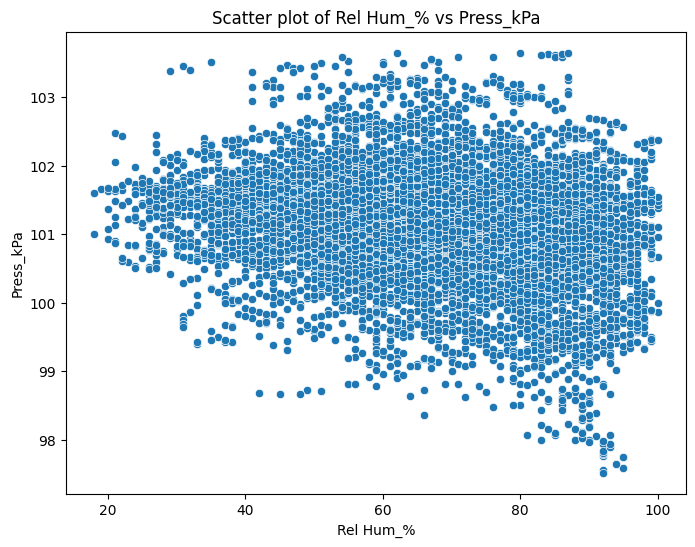

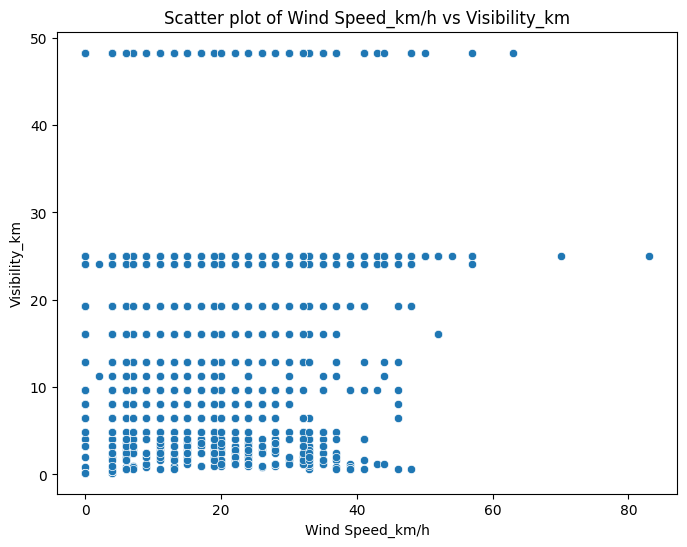

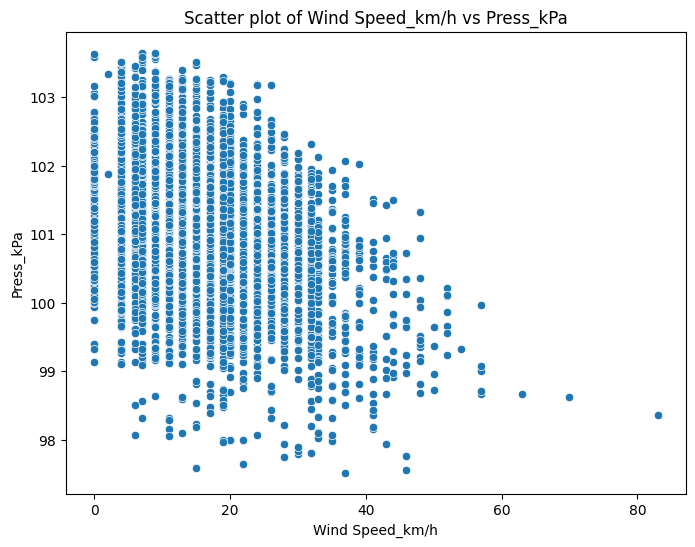

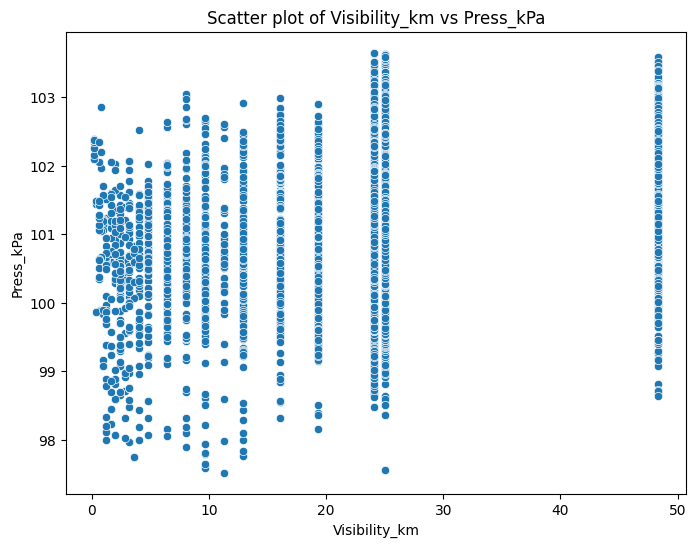

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = df_numerical.columns

for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        col1 = numerical_cols[i]
        col2 = numerical_cols[j]

        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df_numerical, x=col1, y=col2)
        plt.title(f'Scatter plot of {col1} vs {col2}')
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.show()

## Preprocessing

In [13]:
# 1) Parse the column into Pandas datetime  -------------------------
df["Date/Time"] = pd.to_datetime(
    df["Date/Time"],           # original string column
    format="%m/%d/%Y %H:%M",   # matches 1/1/2012 0:00
    errors="coerce"            # bad rows → NaT (you can .dropna later)
)

In [14]:
df["year"]   = df["Date/Time"].dt.year
df["month"]  = df["Date/Time"].dt.month
df["day"]    = df["Date/Time"].dt.day
df["hour"]   = df["Date/Time"].dt.hour
df["weekday"]= df["Date/Time"].dt.weekday

In [15]:
df["hour_sin"]  = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"]  = np.cos(2*np.pi*df["hour"]/24)
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)


In [16]:
df = df.drop("Date/Time",axis=1)

In [17]:
df

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather,year,month,day,hour,weekday,hour_sin,hour_cos,month_sin,month_cos
0,-1.8,-3.9,86,4,8.0,101.24,Fog,2012,1,1,0,6,0.000000,1.000000,5.000000e-01,0.866025
1,-1.8,-3.7,87,4,8.0,101.24,Fog,2012,1,1,1,6,0.258819,0.965926,5.000000e-01,0.866025
2,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog",2012,1,1,2,6,0.500000,0.866025,5.000000e-01,0.866025
3,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog",2012,1,1,3,6,0.707107,0.707107,5.000000e-01,0.866025
4,-1.5,-3.3,88,7,4.8,101.23,Fog,2012,1,1,4,6,0.866025,0.500000,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,0.1,-2.7,81,30,9.7,100.13,Snow,2012,12,31,19,0,-0.965926,0.258819,-2.449294e-16,1.000000
8780,0.2,-2.4,83,24,9.7,100.03,Snow,2012,12,31,20,0,-0.866025,0.500000,-2.449294e-16,1.000000
8781,-0.5,-1.5,93,28,4.8,99.95,Snow,2012,12,31,21,0,-0.707107,0.707107,-2.449294e-16,1.000000
8782,-0.2,-1.8,89,28,9.7,99.91,Snow,2012,12,31,22,0,-0.500000,0.866025,-2.449294e-16,1.000000


In [18]:
df['Weather'].value_counts()

,count
Weather,
Mainly Clear,2106
Mostly Cloudy,2069
Cloudy,1728
Clear,1326
Snow,390
Rain,306
Rain Showers,188
Fog,150
"Rain,Fog",116


In [19]:
df.shape

(8784, 16)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Temp_C            8784 non-null   float64
 1   Dew Point Temp_C  8784 non-null   float64
 2   Rel Hum_%         8784 non-null   int64  
 3   Wind Speed_km/h   8784 non-null   int64  
 4   Visibility_km     8784 non-null   float64
 5   Press_kPa         8784 non-null   float64
 6   Weather           8784 non-null   int64  
 7   year              8784 non-null   int32  
 8   month             8784 non-null   int32  
 9   day               8784 non-null   int32  
 10  hour              8784 non-null   int32  
 11  weekday           8784 non-null   int32  
 12  hour_sin          8784 non-null   float64
 13  hour_cos          8784 non-null   float64
 14  month_sin         8784 non-null   float64
 15  month_cos         8784 non-null   float64
dtypes: float64(8), int32(5), int64(3)
memory u

In [47]:
import pandas as pd
import re


# 2) helper to map → 4 buckets
def simplify_weather(text: str) -> str:
    t = text.lower()
    if re.search(r"rain|drizzle|shower|thunder", t):
        return "raining"
    elif re.search(r"snow|flurr|pellet|freezing", t):
        return "snow"
    elif re.search(r"cloud|fog|haze|mist|blowing", t):
        return "cloudy"
    else:
        return "clear"

df["WeatherSimple"] = df["Weather"].apply(simplify_weather)

# 3) quick sanity check
print(df["WeatherSimple"].value_counts())

# 4) drop the old column if you like
df = df.drop(columns=["Weather"])


WeatherSimple
cloudy     3963
clear      3432
raining     921
snow        468
Name: count, dtype: int64


## Model Training

In [48]:
le = LabelEncoder()
y  = le.fit_transform(df["WeatherSimple"])
X  = df.drop(columns=["WeatherSimple"])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [50]:
weights = "balanced"

In [56]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(
    objective     = "multiclass",
    num_class     = 4,
    n_estimators  = 600,
    learning_rate = 0.05,
    class_weight  = weights,
    random_state  = 42,
    n_jobs        = -1
)

In [57]:
clf.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)])

Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.629468
[200]	valid_0's multi_logloss: 0.54644
[300]	valid_0's multi_logloss: 0.515663
[400]	valid_0's multi_logloss: 0.508762
[500]	valid_0's multi_logloss: 0.506831
Early stopping, best iteration is:
[443]	valid_0's multi_logloss: 0.506357


LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=600,
               n_jobs=-1, num_class=4, objective='multiclass', random_state=42)

In [58]:
y_pred = clf.predict(X_test)
print("Macro-F1 :", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Macro-F1 : 0.797605566766054
              precision    recall  f1-score   support

       clear       0.82      0.86      0.84       686
      cloudy       0.82      0.77      0.79       793
     raining       0.73      0.77      0.75       184
        snow       0.81      0.82      0.81        94

    accuracy                           0.81      1757
   macro avg       0.79      0.80      0.80      1757
weighted avg       0.81      0.81      0.81      1757



##Fine-tune LightGBM in a tight band

In [59]:
def objective_lgbm_small(trial):
    params = dict(
        objective     = "multiclass",
        num_class     = 4,
        metric        = "multi_logloss",
        learning_rate = trial.suggest_float("lr", 0.02, 0.08, log=True),
        n_estimators  = trial.suggest_int("n_estimators", 300, 900),
        max_depth     = trial.suggest_int("max_depth", 4, 12),
        num_leaves    = trial.suggest_int("num_leaves",  20, 120),
        min_child_samples = trial.suggest_int("min_child", 5, 40),
        subsample     = trial.suggest_float("subsample", 0.7, 1.0),
        colsample_bytree=trial.suggest_float("colsample",0.7, 1.0),
        class_weight  = "balanced",
        random_state  = 42,
        n_jobs        = -1,
        verbose       = -1
    )
    cv = lgb.cv(
        params, lgb.Dataset(X_train, y_train),
        nfold=3, stratified=True, seed=42, num_boost_round=10_000,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )
    return -cv[[k for k in cv if k.endswith("-mean")][0]][-1]



In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble    import RandomForestClassifier
from sklearn.pipeline    import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier

logit = Pipeline([("sc", StandardScaler()),
                  ("lr", LogisticRegression(multi_class="multinomial",
                                            C=2.0, max_iter=4000, n_jobs=-1))])

rf = RandomForestClassifier(n_estimators=400, class_weight="balanced",
                            random_state=42, n_jobs=-1)

vote = VotingClassifier(
    estimators=[("lgb",  clf),        # tuned LightGBM
                ("rf",   rf),
                ("logit",logit)],
    voting="soft",
    weights=[0.5, 0.3, 0.2],          # tweak in Optuna if you like
    n_jobs=-1
)
vote.fit(X_train, y_train)
print("Macro-F1 ens:", f1_score(y_test, vote.predict(X_test), average="macro"))


Macro-F1 ens: 0.8030719508283345


In [61]:
def vote_objective(trial):
    w_lgb  = trial.suggest_float("w_lgb",  0.2, 1.0)
    w_rf   = trial.suggest_float("w_rf",   0.0, 1.0)
    w_log  = trial.suggest_float("w_log",  0.0, 1.0)
    s      = w_lgb + w_rf + w_log
    weights= [w_lgb/s, w_rf/s, w_log/s]

    vote = VotingClassifier(
        estimators=[("lgb", clf), ("rf", rf), ("logit", logit)],
        voting="soft", weights=weights, n_jobs=-1
    )
    vote.fit(X_train, y_train)
    y_pred = vote.predict(X_test)
    return f1_score(y_test, y_pred, average="macro")

study_vote = optuna.create_study(direction="maximize")
study_vote.optimize(vote_objective, n_trials=15)
print("Best weights:", study_vote.best_params)


[I 2025-10-02 06:00:48,727] A new study created in memory with name: no-name-1211acd6-8d64-402a-993b-f3acb0779dbf
[I 2025-10-02 06:01:07,404] Trial 0 finished with value: 0.7929139505263032 and parameters: {'w_lgb': 0.6174984606328824, 'w_rf': 0.56161803855299, 'w_log': 0.7257014423666084}. Best is trial 0 with value: 0.7929139505263032.
[I 2025-10-02 06:01:19,909] Trial 1 finished with value: 0.8085490977224922 and parameters: {'w_lgb': 0.7500849174251478, 'w_rf': 0.1075021606469927, 'w_log': 0.05311376073044827}. Best is trial 1 with value: 0.8085490977224922.
[I 2025-10-02 06:01:32,216] Trial 2 finished with value: 0.7852326948238154 and parameters: {'w_lgb': 0.23103376758398886, 'w_rf': 0.4781391436013953, 'w_log': 0.5588956283153323}. Best is trial 1 with value: 0.8085490977224922.
[I 2025-10-02 06:01:43,956] Trial 3 finished with value: 0.8061020273529632 and parameters: {'w_lgb': 0.9788483135103758, 'w_rf': 0.8149130973011338, 'w_log': 0.0809268172223716}. Best is trial 1 with v

Best weights: {'w_lgb': 0.7500849174251478, 'w_rf': 0.1075021606469927, 'w_log': 0.05311376073044827}


In [62]:
from sklearn.calibration import CalibratedClassifierCV

cal_lgb = CalibratedClassifierCV(clf, method='isotonic', cv=3)
cal_lgb.fit(X_train, y_train)
y_pred = cal_lgb.predict(X_test)
print("Calibrated F1:", f1_score(y_test, y_pred, average="macro"))


Calibrated F1: 0.7930371562214888
